In [26]:
import json
import os
import glob
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


class ExperimentLoader:

    def __init__(self, experiment_path):
        self.experiment_path = experiment_path
        self.config = None
        self.run_folders = []
        self.run_data_cache = {}
        

        self._load_config()
        self._find_run_folders()
        self._load_all_run_data()

    def _load_config(self):
        config_path = os.path.join(self.experiment_path, 'experiment.json')
        if not os.path.isfile(config_path):
            # Try finding any .json file if experiment.json doesn't exist
            json_files = glob.glob(os.path.join(self.experiment_path, '*.json'))
            if not json_files:
                 print(f"Warning: No JSON configuration file found in {self.experiment_path}")
                 return # Or raise an error if config is mandatory
            config_path = json_files[0] # Load the first one found
            print(f"Warning: 'experiment.json' not found. Loading {os.path.basename(config_path)} instead.")

        try:
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON from {config_path}: {e}")
        except Exception as e:
            raise IOError(f"Error reading file {config_path}: {e}")

    def _find_run_folders(self):
        """Finds all subdirectories that look like run folders (e.g., 'run_1')."""
        potential_runs = glob.glob(os.path.join(self.experiment_path, 'run_*'))
        self.run_folders = [run for run in potential_runs if os.path.isdir(run)]
        self.run_folders.sort() # Sort them for consistency
        
        
    def _load_run_data(self, run_folder):
        """Loads data from the run.json file in a specific run folder."""
        if run_folder in self.run_data_cache:
            return self.run_data_cache[run_folder]

        file_path = os.path.join(run_folder, "run.json")
        if not os.path.exists(file_path):
            print(f"Warning: File not found {file_path}")
            self.run_data_cache[run_folder] = None
            return None
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                self.run_data_cache[run_folder] = data
                return data
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            self.run_data_cache[run_folder] = None
            return None

    def _load_all_run_data(self):
        """Loads run data for all run folders."""
        for run_folder in self.run_folders:
            self._load_run_data(run_folder) # Load and cache

    def get_all_best_rewards(self):
        """Gets a list of the final best reward from each run."""
        all_best_rewards = []
        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                history = data.get("best_reward_history")
                if history and isinstance(history, list) and len(history) > 0:
                    all_best_rewards.append(float(history[-1])) # Last element is the final best
                else:
                    print(f"Warning: 'best_reward_history' missing, empty, or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        return all_best_rewards

    def avg_best_reward_with_std(self):
        """Calculates the average and sample std dev of the final best reward across all runs."""
        all_best_rewards = self.get_all_best_rewards()

        if not all_best_rewards:
            return np.nan, np.nan

        avg_reward = np.mean(all_best_rewards)
        # Use sample standard deviation (ddof=1)
        std_reward = np.std(all_best_rewards, ddof=1)
        return avg_reward, std_reward

    def get_all_best_fitness(self):
        """Gets a list of the final best fitness from each run."""
        all_best_fitness = []
        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                fitness = data.get("best_fitness")
                if fitness is not None:
                    all_best_fitness.append(float(fitness))
                else:
                    print(f"Warning: 'best_fitness' missing or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        return all_best_fitness

    def avg_best_fitness_with_std(self):
        """Calculates the average and sample std dev of the final best fitness across all runs."""
        all_best_fitness = self.get_all_best_fitness()

        if not all_best_fitness:
            return np.nan, np.nan

        avg_fitness = np.mean(all_best_fitness)
         # Use sample standard deviation (ddof=1)
        std_fitness = np.std(all_best_fitness, ddof=1)
        return avg_fitness, std_fitness

    def avg_best_fitness_per_generation_with_std(self):
        """
        Calculates the average and std dev of the best fitness
        for each generation across all runs, using 'best_fitness_history'.
        """
        all_runs_fitness_logs = []
        min_generations = float('inf')

        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                log_data = data.get("best_fitness_history") # Use best_fitness_history
                if log_data is not None and isinstance(log_data, list) and len(log_data) > 0:
                    all_runs_fitness_logs.append(np.array(log_data))
                    min_generations = min(min_generations, len(log_data))
                else:
                    print(f"Warning: 'best_fitness_history' missing, empty or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        if not all_runs_fitness_logs or min_generations == float('inf'):
            return np.array([]), np.array([])

        # Trim logs to the minimum length found across runs
        trimmed_logs = [log[:min_generations] for log in all_runs_fitness_logs]

        # Stack logs into a 2D array (runs x generations)
        fitness_matrix = np.stack(trimmed_logs, axis=0)

        # Calculate mean and std dev across runs (axis=0) for each generation
        avg_fitness_per_gen = np.mean(fitness_matrix, axis=0)
         # Use sample standard deviation (ddof=1)
        std_fitness_per_gen = np.std(fitness_matrix, axis=0, ddof=1)

        return avg_fitness_per_gen, std_fitness_per_gen

    def avg_best_reward_per_generation_with_std(self):
        """
        Calculates the average and std dev of the best reward
        for each generation across all runs, using 'best_reward_history'.
        """
        all_runs_reward_logs = []
        min_generations = float('inf')

        for run_folder in self.run_folders:
            data = self.run_data_cache.get(run_folder)
            if data:
                log_data = data.get("best_reward_history") # Use best_reward_history
                if log_data is not None and isinstance(log_data, list) and len(log_data) > 0:
                    all_runs_reward_logs.append(np.array(log_data))
                    min_generations = min(min_generations, len(log_data))
                else:
                    print(f"Warning: 'best_reward_history' missing, empty or invalid in {os.path.join(run_folder, 'run.json')}")
            # else: Warning already printed during loading

        if not all_runs_reward_logs or min_generations == float('inf'):
            return np.array([]), np.array([])

        # Trim logs
        trimmed_logs = [log[:min_generations] for log in all_runs_reward_logs]

        # Stack logs into a 2D array (runs x generations)
        reward_matrix = np.stack(trimmed_logs, axis=0)

        # Calculate mean and std dev across runs (axis=0) for each generation
        avg_reward_per_gen = np.mean(reward_matrix, axis=0)
        # Use sample standard deviation (ddof=1)
        std_reward_per_gen = np.std(reward_matrix, axis=0, ddof=1)

        return avg_reward_per_gen, std_reward_per_gen


In [ ]:

ea_alt_gait = ExperimentLoader("results/task1/Walker-v0/EA_alt_gait_controller_Test_D12_M04_23_02")
ea_hopping = ExperimentLoader("results/task1/Walker-v0/EA_hopping_controller_Test_D12_M04_23_31")
ea_sinusoidal = ExperimentLoader("results/task1/Walker-v0/EA_sinusoidal_controller_Test_D12_M04_16_48")

print("EA_alt_gait")
print("Average Best Reward:", ea_alt_gait.avg_best_reward_with_std())
print("Average Best Fitness:", ea_alt_gait.avg_best_fitness_with_std())

print("EA_hopping")
print("Average Best Reward:", ea_hopping.avg_best_reward_with_std())
print("Average Best Fitness:", ea_hopping.avg_best_fitness_with_std())

print("EA_sinusoidal")
print("Average Best Reward:", ea_sinusoidal.avg_best_reward_with_std())
print("Average Best Fitness:", ea_sinusoidal.avg_best_fitness_with_std())


EA_alt_gait
Average Best Reward: (6.186348912018189, 1.1071750329393344)
Average Best Fitness: (6.186348912018189, 1.1071750329393344)
EA_hopping
Average Best Reward: (5.922204232802509, 0.9737410273181688)
Average Best Fitness: (5.922204232802509, 0.9737410273181688)
EA_sinusoidal
Average Best Reward: (3.183650448966964, 0.38657946207129407)
Average Best Fitness: (3.183650448966964, 0.38657946207129407)


In [28]:
#Statistical Tests definitions

def kruskal_wallis(data):
    """
    non parametric
    many samples
    independent
    """     
    H,pval = st.kruskal(*data)
    return (H,pval)

def mann_whitney(data1,data2):
    """
    non parametric
    two samples
    independent
    """    
    return st.mannwhitneyu(data1, data2)

In [29]:
# --- Load final best rewards ---
# in this case rewards were the same as fitness

alt_rewards = ea_alt_gait.get_all_best_rewards()
hopping_rewards = ea_hopping.get_all_best_rewards()
sinusoidal_rewards = ea_sinusoidal.get_all_best_rewards()

labels = ["alt_gait", "hopping", "sinusoidal"]
reward_data = [alt_rewards, hopping_rewards, sinusoidal_rewards]


In [30]:
# --- Kruskal-Wallis Test ---
H, p_kw = kruskal_wallis(reward_data)
print("\n Kruskal-Wallis Test:")
print(f"H-statistic = {H:.3f}, p-value = {p_kw:.5f}")

# --- Mann-Whitney Pairwise Comparisons ---
pairs = [("alt_gait", alt_rewards, "hopping", hopping_rewards),
         ("alt_gait", alt_rewards, "sinusoidal", sinusoidal_rewards),
         ("hopping", hopping_rewards, "sinusoidal", sinusoidal_rewards)]

alpha = 0.05
corrected_alpha = alpha / len(pairs)

print(f"\n Mann-Whitney U Tests (Bonferroni corrected α = {corrected_alpha:.5f}):")
for name1, data1, name2, data2 in pairs:
    U, p = mann_whitney(data1, data2)
    n1, n2 = len(data1), len(data2)
    # Effect size
    n = n1 + n2
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n + 1) / 12)
    z = (U - mean_U) / std_U
    r = z / np.sqrt(n)

    significance = " Significant" if p < corrected_alpha else " Not significant"
    print(f"{name1} vs {name2} -> p = {p:.5f}, effect size r = {r:.3f} → {significance}")



 Kruskal-Wallis Test:
H-statistic = 9.500, p-value = 0.00865

 Mann-Whitney U Tests (Bonferroni corrected α = 0.01667):
alt_gait vs hopping -> p = 0.69048, effect size r = 0.165 →  Not significant
alt_gait vs sinusoidal -> p = 0.00794, effect size r = 0.826 →  Significant
hopping vs sinusoidal -> p = 0.00794, effect size r = 0.826 →  Significant



 Summary (Median ± Std):
alt_gait: 6.41 ± 1.11
hopping: 5.66 ± 0.97
sinusoidal: 3.19 ± 0.39


/var/folders/25/rb9t435n4mzgnk1l82dg2c1c0000gn/T/ipykernel_66378/1731172480.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(reward_data, labels=labels)


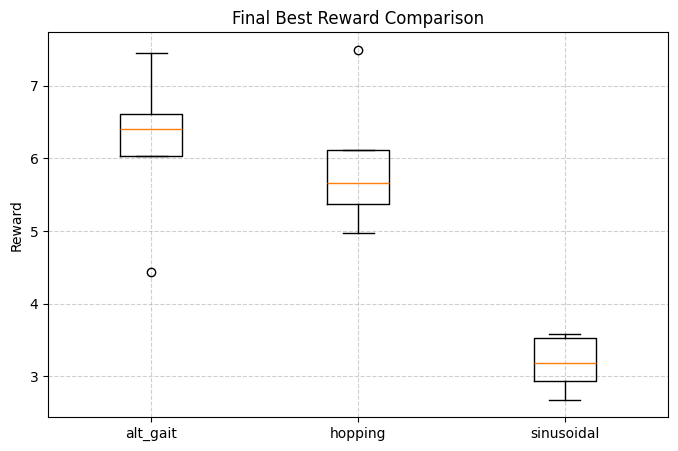

In [31]:
# --- Summary Statistics ---
print("\n Summary (Median ± Std):")
for name, data in zip(labels, reward_data):
    print(f"{name}: {np.median(data):.2f} ± {np.std(data, ddof=1):.2f}")

# --- Optional: Boxplot for visual comparison ---
plt.figure(figsize=(8, 5))
plt.boxplot(reward_data, labels=labels)
plt.title("Final Best Reward Comparison")
plt.ylabel("Reward")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()